In [1]:
import tensorflow as tf

using_gpu_index = 0 # 使用的 GPU 号码
gpu_list = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
        gpu_list[using_gpu_index],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4.75)]
    )

from quafu import User

# user = User(
#     "YOU API")
# user.save_apitoken()

2023-10-16 19:11:26.839862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 19:11:26.845775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 19:11:26.845911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
import cirq
import models.quantum_genotypes as genotypes

from models.quantum_models import generate_model_policy
from functools import reduce

env_name = "CartPole-v1"
qubits = cirq.GridQubit.rect(1, 4)
genotype = genotypes.ORI_TYPE_CP
n_actions = 2  # Number of actions in CartPole

ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x * y), ops)]  # Z_0*Z_1*Z_2*Z_3
# generate_model_policy(qubits, genotype, n_actions, beta, observables, env):
model = generate_model_policy(qubits, genotype, n_actions, 1., observables, env_name, using_H=True)

2023-10-16 19:11:28.533283: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 19:11:28.534352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 19:11:28.534483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 19:11:28.534543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

CartPole-v1


In [3]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_quantum as tfq
import cirq, sympy
from functools import reduce
import numpy as np
class ValueNet(tf.keras.Model):
    """
    价值网络
    """

    def __init__(self, hidden_dim):
        super().__init__()
        self.model = Sequential(
            [
                Dense(units=hidden_dim, activation=tf.nn.tanh),
                Dense(units=hidden_dim, activation=tf.nn.tanh),
                Dense(units=1),
            ]
        )
        pass

    def call(self, inputs):
        return self.model(inputs)
        pass

In [4]:
from IPython.core.display import HTML
from models.quantum_models import generate_circuit

circuit, params, inputs = generate_circuit(qubits, genotype, using_H=True)
display(HTML(f"<pre>{circuit}</pre>"))

In [5]:
env_name = "CartPole-v1"
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 64

# device = torch.device("cpu")

actor = model

critic = ValueNet(hidden_dim=hidden_dim)  # 价值网络
# 广义优势估计（Generalized Advantage Estimation，GAE）
# gamma 是GAE的超参数
gamma = 0.98

# lmbda 也用来计算广义优势估
lmbda = 0.95

epochs = 10  # 一条序列的数据用来训练轮数
eps = 0.2  # 裁剪超参数
# actor_lr = 1e-3
# critic_lr = 1e-2
critic_lr = 1e-1

# actor_optimizer = Adam(learning_rate=actor_lr)

optimizer_in = Adam(learning_rate=0.1, amsgrad=True)
optimizer_var = Adam(learning_rate=0.01, amsgrad=True)
optimizer_out = Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

# critic_optimizer = Adam(learning_rate=critic_lr)
critic_optimizer = Adam(learning_rate=critic_lr, amsgrad=True)

In [6]:
# import numpy as np
# 计算优势函数


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.numpy()
    advantage_list = []
    advantage = 0.0

    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)

    advantage_list.reverse()
    advantage_list = np.array(advantage_list)
    advantage_list = (advantage_list - np.mean(advantage_list)) / (
        np.std(advantage_list) + 1e-8
    )  # 标准化
    return tf.convert_to_tensor(advantage_list, dtype=tf.float32)

In [7]:
from misc.utils import get_quafu_exp_


def compute_by_quafu(states, actor):
    # 得到actor中的参数
    theta, lamda = actor.get_layer('nsganet_PQC').get_weights()
    out = []
    for state in states:
        circuit, _, _ = generate_circuit(qubits, genotype, theta[0], lamda, state, using_H=True)
        taskid, ob = get_quafu_exp_(circuit, n_qubits=4, backend_quafu='ScQ-P136', shots=1000)
        print(' ')


        out.append(ob)


    # 得到后面的层
    obs_policy = actor.get_layer("observables-policy")
    return obs_policy(tf.convert_to_tensor(out))

In [8]:
# import pandas as pd
# 
# df = pd.read_csv('./return_list_actor_normalize4.csv')
# 
# # 提取DataFrame中的数据列并将其转换为列表
# my_list = df['episode_reward_history'].tolist()
# return_list = my_list

In [ ]:
# return_list

In [10]:
# critic(tf.convert_to_tensor([[1., 1., 1., 1.]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.45291728]], dtype=float32)>

In [11]:
# actor.load_weights('./weights_CP_ACTOR_NORMALIZE_ACTOR4.h5')
# critic.load_weights('./weights_CP_ACTOR_NORMALIZE_CRITIC4.h5')

In [12]:
def normalized_state(s, ub, lb):
    return -1 + 2 * (s - lb) / (ub - lb)

In [ ]:
num_episodes = 1000
return_list = []

state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
state_ub = state_bounds
state_lb = -1 * state_bounds
env = gym.make(env_name)
for cur_episode in range(num_episodes):
    # sample_one_episode_history
    episode_return = 0
    history_dict = {
        "states": [],
        "norm_state": [],
        "actions": [],
        "next_states": [],
        "rewards": [],
        "dones": [],
    }
    state, _ = env.reset()  # gym=0.26.x
    # state = state / state_bounds  #
    norm_state = normalized_state(state, state_ub, state_lb)  #
    done = False
    while not done:
        # actor根据策略采取行动
        # probs = actor(tf.convert_to_tensor([state]))
        probs = compute_by_quafu(tf.convert_to_tensor([norm_state]), actor)
        probs = probs[0].numpy()
        action = np.random.choice(range(len(probs)), p=probs)
        # 记录
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated  # gym=0.26.x

        # next_state = next_state / state_bounds  #

        history_dict["states"].append(state)
        history_dict["norm_state"].append(norm_state)
        history_dict["actions"].append(action)
        history_dict["next_states"].append(next_state)
        history_dict["rewards"].append([reward])
        history_dict["dones"].append([done])
        state = next_state
        norm_state = normalized_state(next_state, state_ub, state_lb)  #
        episode_return += reward

    return_list.append(episode_return)
    avg = np.mean(return_list[-10:])
    print(f"当前迭代次数为：{cur_episode}, 当前奖励为：{episode_return}, 平均奖励为：{avg}")
    if episode_return >= 100:
        break

    # update_in_one_episode
    
    # prepare data
    states = tf.convert_to_tensor(history_dict["states"], dtype=tf.float32)
    norm_states = tf.convert_to_tensor(history_dict["norm_state"], dtype=tf.float32)
    actions = tf.convert_to_tensor(history_dict["actions"], dtype=tf.int32)
    rewards = tf.convert_to_tensor(history_dict["rewards"], dtype=tf.float32)
    next_states = tf.convert_to_tensor(
        history_dict["next_states"], dtype=tf.float32)
    dones = tf.convert_to_tensor(history_dict["dones"], dtype=tf.float32)
    td_target = rewards + gamma * critic(next_states) * (1 - dones)
    td_delta = td_target - critic(states)
    advantage = compute_advantage(gamma, lmbda, td_delta)  # 广义优势函数
    old_log_probs = tf.math.log(
        tf.expand_dims(
            tf.boolean_mask(
                # actor(states),
                compute_by_quafu(norm_states, actor),
                tf.one_hot(actions, depth=action_dim, dtype=tf.int32),
            ),
            axis=1,
        )
    )

    for _ in range(epochs):
        
    
        probs = actor(norm_states)
        probs_ = compute_by_quafu(norm_states, actor)
        delta = tf.constant(probs_ - probs)
        # probs = probs + delta
        
        # update policy_net
        with tf.GradientTape() as tape_policy:
            
            probs = actor(norm_states)
            
            probs = probs + delta
            log_probs = tf.math.log(
                tf.expand_dims(
                    tf.boolean_mask(
                        # actor(states),
                        probs,
                        tf.one_hot(actions, depth=action_dim, dtype=tf.int32),
                    ),
                    axis=1,
                )
            )
            ratio = tf.math.exp(log_probs - old_log_probs)  # exp(ln a - ln b) = a/b
            surr1 = ratio * advantage
            surr2 = tf.clip_by_value(ratio, 1 - eps, 1 + eps) * advantage  # 截断
            actor_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))  # PPO损失函数
            policy_gradients = tape_policy.gradient(
                actor_loss, actor.trainable_variables
            )
        for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
            optimizer.apply_gradients([(policy_gradients[w], actor.trainable_variables[w])])

        # update value_net
        with tf.GradientTape() as tape_value:
            critic_loss = tf.reduce_mean(
                tf.losses.mean_squared_error(critic(states), td_target)
            )
            value_gradients = tape_value.gradient(
                critic_loss, critic.trainable_variables
            )

        critic_optimizer.apply_gradients(
            grads_and_vars=zip(value_gradients, critic.trainable_variables)
        )

In [33]:
import pandas as pd

# 创建一个DataFrame对象
df = pd.DataFrame({'episode_reward_history': return_list})

# 将DataFrame保存到CSV文件
df.to_csv('./return_list_actor_normalize4.csv', index=False)  # 可以指定文件名和是否包括行索引
actor.save_weights('./weights_CP_ACTOR_NORMALIZE_ACTOR4.h5')
critic.save_weights('./weights_CP_ACTOR_NORMALIZE_CRITIC4.h5')

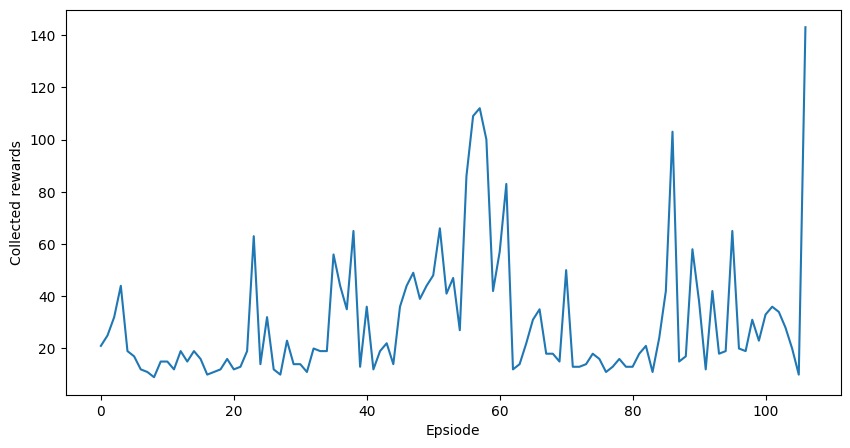

In [14]:
from matplotlib import pyplot as plt

# validate
plt.figure(figsize=(10,5))
plt.plot(return_list)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()